In [2]:
%%javascript
 
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('up');
Jupyter.keyboard_manager.command_shortcuts.remove_shortcut('down')


<IPython.core.display.Javascript object>

In [3]:
import pandas as pd
import calendar
from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sn
import matplotlib.dates as mdates
from scipy import stats
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from xgboost import XGBClassifier
import _pickle as cPickle
from matplotlib.dates import DateFormatter
import warnings
warnings.filterwarnings("ignore")

%matplotlib inline

In [4]:
initial_df = pd.read_csv("sensordata.csv") #importing the data

In [5]:
initial_df.head() #checking 5 rows

,id,sensor_id,value,start_time,end_time,duration,is_original
0,4995613,3802,0.0,"""2017-06-01T04:00:00.000Z""","""2017-06-01T10:20:32.000Z""",22831.650,0
1,4998293,3802,1.0,"""2017-06-01T10:20:32.000Z""","""2017-06-01T10:36:28.000Z""",956.049,1
2,4998417,3802,0.0,"""2017-06-01T10:36:28.000Z""","""2017-06-01T18:50:48.000Z""",29660.478,1
3,5002921,3802,1.0,"""2017-06-01T18:50:48.000Z""","""2017-06-01T18:54:47.000Z""",239.122,1
4,5002934,3802,0.0,"""2017-06-01T18:54:47.000Z""","""2017-06-01T18:59:02.000Z""",254.407,1


In [6]:
initial_df.shape #dimensions of data

(4666, 7)

In [7]:
initial_df.describe()

,id,sensor_id,value,duration,is_original
count,4.666000e+03,4666.000000,4666.000000,4666.000000,4666.000000
mean,5.125967e+06,3804.529361,52.561812,2200.581414,0.983069
std,5.966069e+04,1.578016,41.006633,7909.959593,0.129027
min,4.995613e+06,3802.000000,0.000000,0.050000,0.000000
25%,5.092501e+06,3803.000000,5.000000,900.000000,1.000000
50%,5.131490e+06,3804.000000,51.666667,900.000000,1.000000
75%,5.173210e+06,3805.000000,76.750000,900.000000,1.000000
max,5.217490e+06,3809.000000,218.000000,86400.000000,1.000000


### Lets remove the id column as it has all unique values and this does not help us in any way

In [8]:
initial_df.id.value_counts().head()

5124090    1
5159244    1
5085347    1
5184190    1
5010111    1
Name: id, dtype: int64

In [9]:
initial_df.drop("id",axis=1,inplace=True)

In [10]:
initial_df.isnull().sum() #looking for any null values

sensor_id      0
value          0
start_time     0
end_time       0
duration       0
is_original    0
dtype: int64

In [11]:
initial_df.dtypes #type of columns

sensor_id        int64
value          float64
start_time      object
end_time        object
duration       float64
is_original      int64
dtype: object

## Lets first change each column to their respective category

In [12]:
initial_df['sensor_id'] = initial_df.sensor_id.astype("category")
initial_df['is_original'] = initial_df.is_original.astype("category")

In [13]:
#cleaning the start and end time
initial_df['start_time'] = initial_df['start_time'].astype("str")
initial_df['start_time'] = initial_df['start_time'].str.replace('T',' ')
initial_df['start_time'] = initial_df['start_time'].str.replace('Z','')

initial_df['end_time'] = initial_df['end_time'].str.replace('T',' ')
initial_df['end_time'] = initial_df['end_time'].str.replace('Z','')

initial_df['start_time'] = initial_df.start_time.str[1:-1]
initial_df['end_time'] = initial_df.end_time.str[1:-1]

### Lets start off by some analysis by creating few features

In [14]:
initial_df['start_time'] = initial_df.start_time.astype("str")
initial_df["value"] = initial_df.value.astype(int)
initial_df["date"] = initial_df.start_time.apply(lambda x : x.split()[0])
initial_df['day'] = initial_df.start_time.apply(lambda x : x.split()[0].split("-")[2])
initial_df["hour"] = initial_df.start_time.apply(lambda x : x.split()[1].split(":")[0])
initial_df["minute"] = initial_df.start_time.apply(lambda x : x.split()[1].split(":")[1])
initial_df["weekday"] = initial_df.date.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
initial_df['date'] = pd.to_datetime(initial_df['date'], format='%Y-%m-%d')

initial_df["sensor"] = initial_df.sensor_id.map({3802: "In Shower", 3803 : "Temperature in Shower",
                                                 3804 : "Light Levels in Shower", 3805 :"Humidity in Shower",
                                                 3807 : "In Bathroom", 3809 : "Toilet Flushed, Master" })


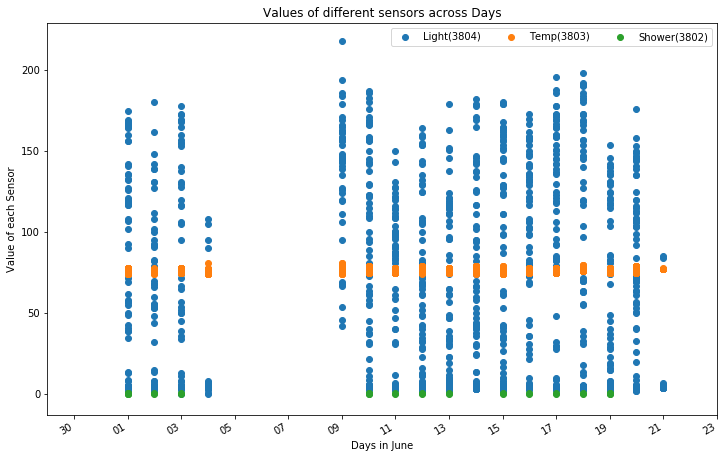

In [15]:
import datetime
myFmt = DateFormatter("%d")

fig, axes = plt.subplots()
fig.set_size_inches(12,8)

light_levels = initial_df[(initial_df.sensor_id == 3804) & (initial_df.is_original == 1)]
temp_in_shower = initial_df[(initial_df.sensor_id == 3803) & (initial_df.is_original == 1)]
shower_duration = initial_df[(initial_df.sensor_id == 3802) & (initial_df.is_original == 1)]

light = plt.scatter((light_levels.date).tolist(), light_levels['value'])
temp = plt.scatter((temp_in_shower.date).tolist(), temp_in_shower['value'])
shower = plt.scatter((shower_duration.date).tolist(), shower_duration['value'])

axes.xaxis.set_major_formatter(myFmt) 
axes.set_xlim([datetime.date(int(2017), int(5), int(29)), datetime.date(int(2017), int(6), int(23))])

axes.xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d'))



plt.legend((light,temp, shower),
           ('Light(3804)', 'Temp(3803)', 'Shower(3802)'),
           scatterpoints=1,
           loc='top right',
           ncol=3,
           fontsize=10)

axes.set(xlabel='Days in June', ylabel='Value of each Sensor',
         
         title="Values of different sensors across Days",label='big')

plt.gcf().autofmt_xdate()


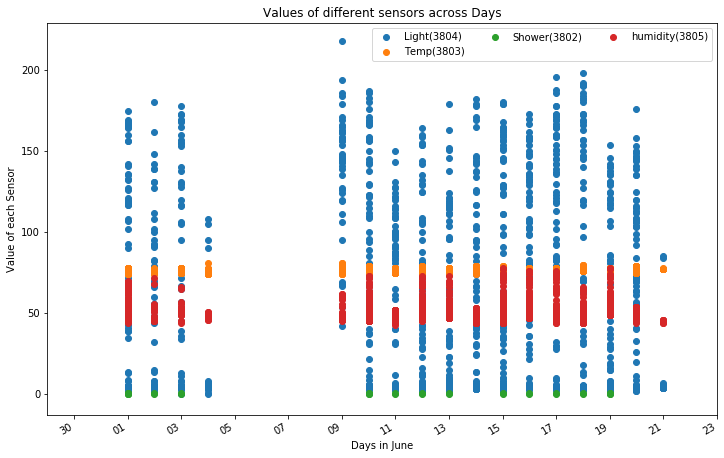

In [25]:
import datetime
myFmt = DateFormatter("%d")

fig, axes = plt.subplots()
fig.set_size_inches(12,8)

light_levels = initial_df[(initial_df.sensor_id == 3804) & (initial_df.is_original == 1)]
temp_in_shower = initial_df[(initial_df.sensor_id == 3803) & (initial_df.is_original == 1)]
shower_duration = initial_df[(initial_df.sensor_id == 3802) & (initial_df.is_original == 1)]
humidity_shower = initial_df[(initial_df.sensor_id == 3805) & (initial_df.is_original == 1)]

light = plt.scatter((light_levels.date).tolist(), light_levels['value'])
temp = plt.scatter((temp_in_shower.date).tolist(), temp_in_shower['value'])
shower = plt.scatter((shower_duration.date).tolist(), shower_duration['value'])
humidity = plt.scatter((humidity_shower.date).tolist(), humidity_shower['value'])

axes.xaxis.set_major_formatter(myFmt) 
axes.set_xlim([datetime.date(int(2017), int(5), int(29)), datetime.date(int(2017), int(6), int(23))])

axes.xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d'))



plt.legend((light,temp, shower, humidity),
           ('Light(3804)', 'Temp(3803)', 'Shower(3802)', 'humidity(3805)'),
           scatterpoints=1,
           loc='top right',
           ncol=3,
           fontsize=10)

axes.set(xlabel='Days in June', ylabel='Value of each Sensor',         
         title="Values of different sensors across Days",label='big')

plt.gcf().autofmt_xdate()

[Text(0, 0.5, 'Hours'),
 Text(0.5, 0, 'Days in June'),
 Text(0.5, 1.0, 'Values of Light sensor across Days and Hours'),
 None]

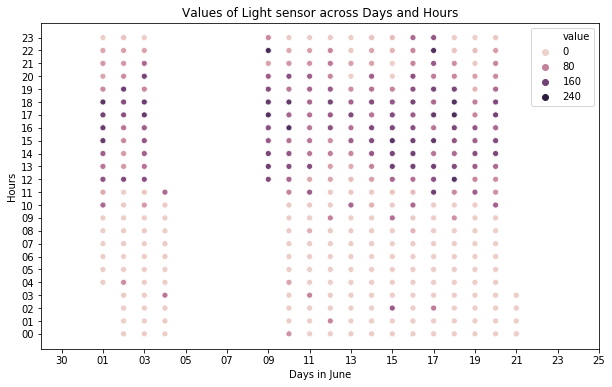

In [16]:
fig, axes = plt.subplots()
fig.set_size_inches(10,6)

light_levels_sorted = light_levels.sort_values(['hour','date'])
sn.scatterplot(x=light_levels_sorted["date"], y=light_levels_sorted["hour"],
               hue=light_levels_sorted["value"])

axes.xaxis.set_major_formatter(myFmt) 
axes.set_xlim([datetime.date(int(2017), int(5), int(29)), datetime.date(int(2017), int(6), int(25))])

axes.xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

axes.set(xlabel='Days in June', ylabel='Hours',
         title="Values of Light sensor across Days and Hours",label='big')


[Text(0, 0.5, 'Hours'),
 Text(0.5, 0, 'Days in June'),
 Text(0.5, 1.0, 'Values of Temparature sensor across Days and Hours'),
 None]

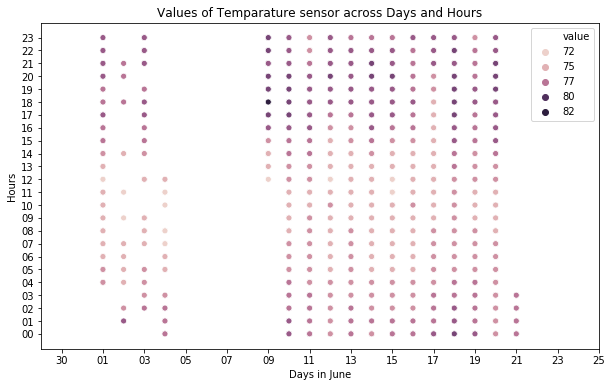

In [17]:
fig, axes = plt.subplots()
fig.set_size_inches(10,6)

temp_in_shower_sorted = temp_in_shower.sort_values(['hour','date'])
sn.scatterplot(x=temp_in_shower_sorted["date"], y=temp_in_shower_sorted["hour"],
               hue=temp_in_shower_sorted["value"])

axes.xaxis.set_major_formatter(myFmt) 
axes.set_xlim([datetime.date(int(2017), int(5), int(29)), datetime.date(int(2017), int(6), int(25))])

axes.xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

axes.set(xlabel='Days in June', ylabel='Hours',
         title="Values of Temparature sensor across Days and Hours",label='big')

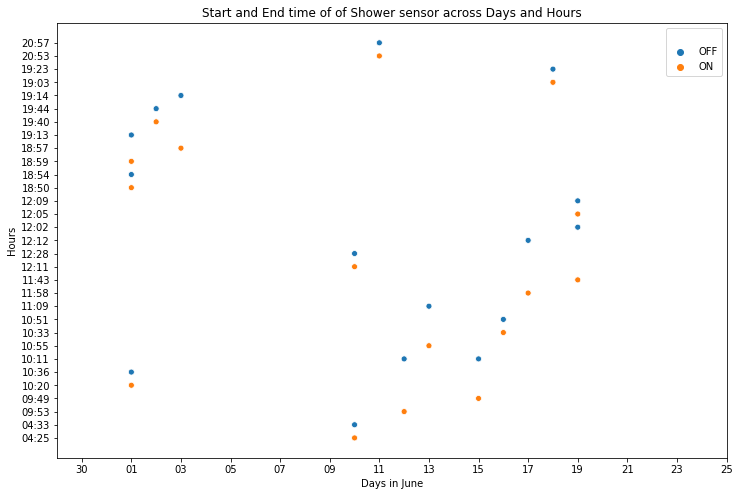

In [18]:
fig, axes = plt.subplots()
fig.set_size_inches(12,8)


shower_duration['hour_minute'] = shower_duration.hour  + ":" + shower_duration.minute
shower_duration_sorted = shower_duration.sort_values(['hour','date'])

shower_on_off = sn.scatterplot(x=shower_duration_sorted["date"], y=shower_duration_sorted["hour_minute"],
               hue=shower_duration_sorted["value"],  )

axes.xaxis.set_major_formatter(myFmt) 
axes.set_xlim([datetime.date(int(2017), int(5), int(29)), datetime.date(int(2017), int(6), int(25))])

axes.xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

axes.set(xlabel='Days in June', ylabel='Hours',
         title="Start and End time of of Shower sensor across Days and Hours",label='big')

new_labels = ['', 'OFF',"ON"]
for t, l in zip(shower_on_off.legend_.texts, new_labels): t.set_text(l)


In [20]:
concatenated.head()

,sensor_id,value,start_time,end_time,duration,is_original,date,day,hour,minute,weekday,sensor,dataset
0,3802,0,2017-06-01 04:00:00.000,2017-06-01 10:20:32.000,22831.650,0,2017-06-01,1,4,0,Thursday,In Shower,one_day_shower
1,3802,1,2017-06-01 10:20:32.000,2017-06-01 10:36:28.000,956.049,1,2017-06-01,1,10,20,Thursday,In Shower,one_day_shower
2,3802,0,2017-06-01 10:36:28.000,2017-06-01 18:50:48.000,29660.478,1,2017-06-01,1,10,36,Thursday,In Shower,one_day_shower
3,3802,1,2017-06-01 18:50:48.000,2017-06-01 18:54:47.000,239.122,1,2017-06-01,1,18,50,Thursday,In Shower,one_day_shower
4,3802,0,2017-06-01 18:54:47.000,2017-06-01 18:59:02.000,254.407,1,2017-06-01,1,18,54,Thursday,In Shower,one_day_shower


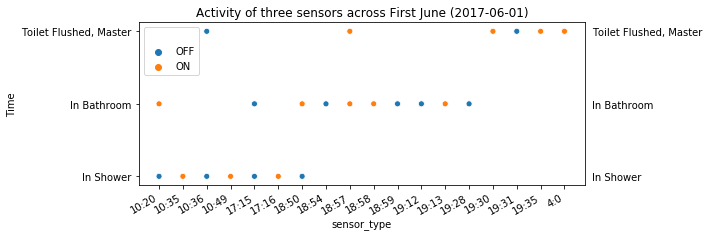

In [22]:
time_based_values = initial_df[(initial_df.is_original == 1) & (initial_df.sensor_id == 3809) | 
                               (initial_df.sensor_id == 3802) | (initial_df.sensor_id == 3807)  ]
time_based_values.to_csv("time_based_values.csv", index=False)
time_based_values = pd.read_csv("time_based_values.csv")

time_based_values['hour'] = time_based_values.hour.astype(str)
time_based_values['minute'] = time_based_values.minute.astype(str)
time_based_values['hour_minute'] = time_based_values.hour  + ":" + time_based_values.minute


fig, axes = plt.subplots()
fig.set_size_inches(8,3)

shower_duration = time_based_values[time_based_values.sensor_id == 3802]
one_day_shower  = shower_duration[shower_duration.date == '2017-06-01']

bath_duration = time_based_values[time_based_values.sensor_id == 3807]
one_day_bath = bath_duration[bath_duration.date == '2017-06-01']

flushed_duration = time_based_values[time_based_values.sensor_id == 3809]
one_day_flushed  = flushed_duration[flushed_duration.date == '2017-06-01']

concatenated = pd.concat([one_day_shower.assign(dataset='one_day_shower'), 
                          one_day_bath.assign(dataset='one_day_bath'),
                         one_day_flushed.assign(dataset = 'one_day_flushed')])


shower_bath = sn.scatterplot(x='hour_minute', y='sensor', hue='value', data=concatenated,)
new_labels = ["",'OFF',"ON"]
for t, l in zip(shower_bath.legend_.texts, new_labels): t.set_text(l)

x_dates = concatenated['hour_minute'].sort_values().unique()
axes.set_xticklabels(labels=x_dates, rotation=30, ha='right')  

axes.tick_params(labelright=True)
axes.set(xlabel='sensor_type', ylabel='Time',         
         title="Activity of three sensors across First June (2017-06-01)",label='big')


plt.show()


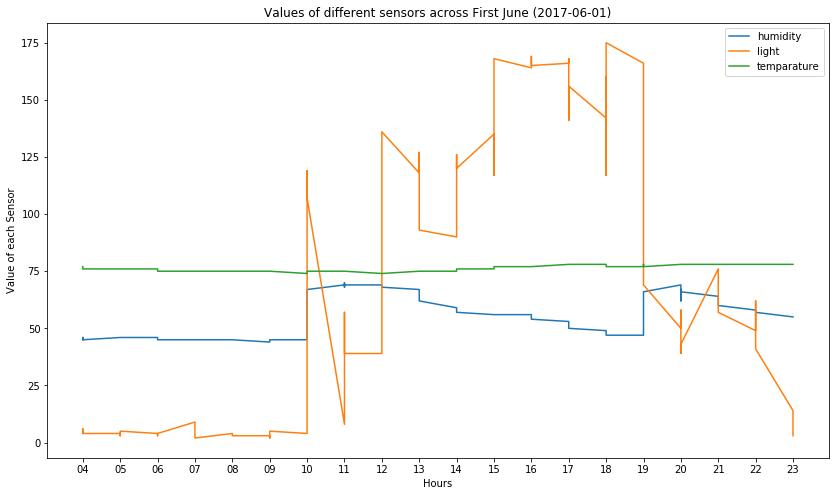

In [26]:
fig,ax = plt.subplots()
fig.set_size_inches(14,8)
one_day_humidity  = humidity_shower[humidity_shower.date == '2017-06-01']
one_day_light = light_levels[light_levels.date == '2017-06-01']
one_day_temp = temp_in_shower[temp_in_shower.date == '2017-06-01']

ax.plot(one_day_humidity.hour, one_day_humidity.value, label='humidity')
ax.plot(one_day_light.hour, one_day_light.value, label = 'light')
ax.plot(one_day_temp.hour, one_day_temp.value, label = 'temparature')


ax.set(xlabel='Hours', ylabel='Value of each Sensor',         
         title="Values of different sensors across First June (2017-06-01)",label='big')


ax.legend()
plt.show()

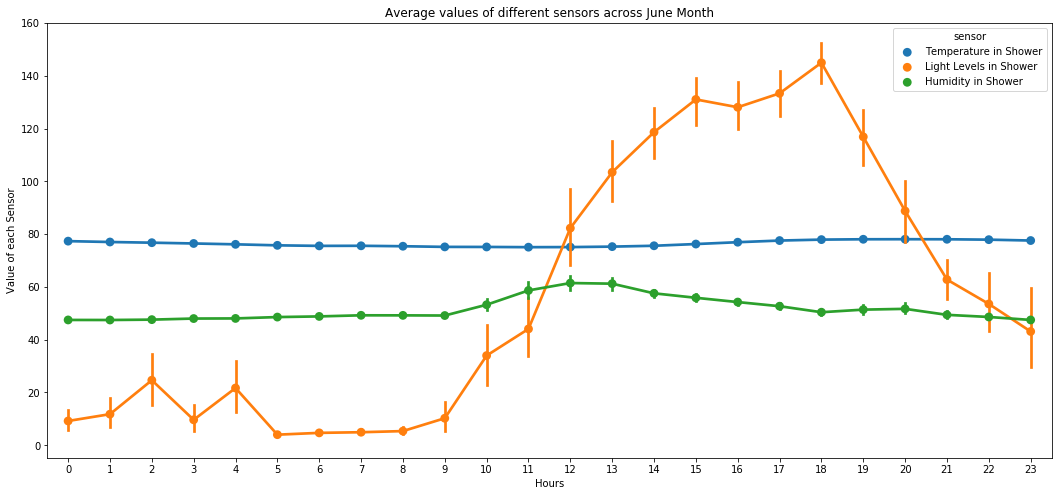

In [23]:
value_based_sensors = pd.DataFrame(initial_df.query('sensor_id == 3803 | sensor_id == 3804 | sensor_id == 3805'))
value_based_sensors.to_csv("value_based_sensors.csv",index=False)
value_based_sensors = pd.read_csv("value_based_sensors.csv")

fig,ax = plt.subplots()
fig.set_size_inches(18,8)

hourAggregated = pd.DataFrame(value_based_sensors.groupby(["hour","sensor"])["value"].mean()).reset_index()
sn.pointplot(x=value_based_sensors["hour"], y=value_based_sensors["value"],
             hue=value_based_sensors["sensor"], data=value_based_sensors)

x_dates = value_based_sensors['hour'].sort_values().unique()
# ax.set_xticklabels(labels=x_dates, rotation=45, ha='right')


ax.set(xlabel='Hours', ylabel='Value of each Sensor',         
         title="Average values of different sensors across June Month",label='big')



plt.show()

[Text(0, 0.5, 'Hours'),
 Text(0.5, 0, 'Days in June'),
 Text(0.5, 1.0, 'Values of Humidity sensor across Days and Hours'),
 None]

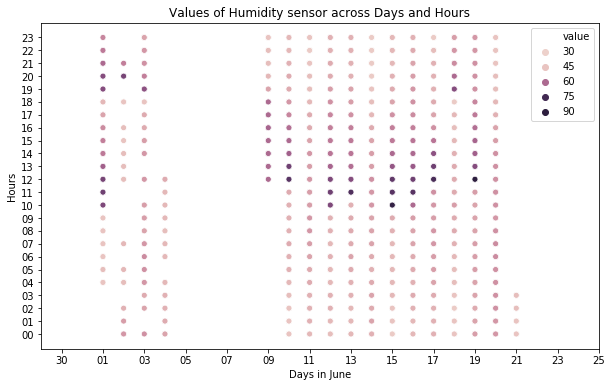

In [22]:
humidity_levels = initial_df[(initial_df.sensor_id == 3805) & (initial_df.is_original == 1)]

fig, axes = plt.subplots()
fig.set_size_inches(10,6)

humidity_levels = humidity_levels.sort_values(['hour','date'])
sn.scatterplot(x=humidity_levels["date"], y=humidity_levels["hour"],
               hue=humidity_levels["value"])

axes.xaxis.set_major_formatter(myFmt) 
axes.set_xlim([datetime.date(int(2017), int(5), int(29)), datetime.date(int(2017), int(6), int(25))])

axes.xaxis.set_major_locator(mdates.DayLocator(interval=2))
axes.xaxis.set_major_formatter(mdates.DateFormatter('%d'))

axes.set(xlabel='Days in June', ylabel='Hours',
         title="Values of Humidity sensor across Days and Hours",label='big')


[Text(0, 0.5, 'Value'),
 Text(0.5, 0, 'is_original'),
 Text(0.5, 1.0, 'Box Plot On Value Across Is_original')]

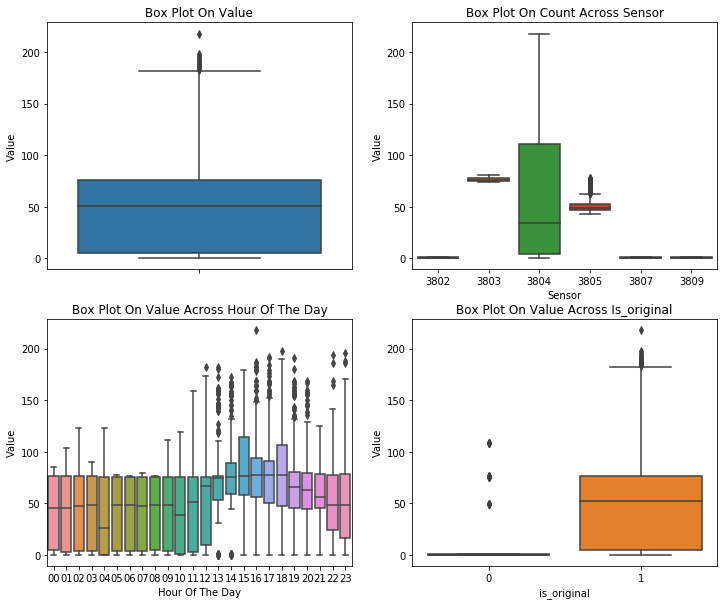

In [23]:
fig, axes = plt.subplots(nrows=2,ncols=2)

fig.set_size_inches(12, 10)

sn.boxplot(data=initial_df,y="value",orient="v",ax=axes[0][0]) #to plot boxplot of count column

sn.boxplot(data=initial_df,y="value",x="sensor_id",orient="v",ax=axes[0][1])
    
sn.boxplot(data=initial_df,y="value",x="hour",orient="v",ax=axes[1][0])

sn.boxplot(data=initial_df,y="value",x="is_original",orient="v",ax=axes[1][1])


axes[0][0].set(ylabel='Value',title="Box Plot On Value") 
axes[0][1].set(xlabel='Sensor', ylabel='Value',title="Box Plot On Count Across Sensor") 
axes[1][0].set(xlabel='Hour Of The Day', ylabel='Value',title="Box Plot On Value Across Hour Of The Day")
axes[1][1].set(xlabel='is_original', ylabel='Value',title="Box Plot On Value Across Is_original")

### Rule based algorithm to predict shower duration 

In [24]:
shower_activity_recognition = initial_df[(initial_df.sensor_id == 3802) & (initial_df.is_original ==1) & 
                                         (initial_df.value == 1)]


shower_activity_recognition.drop("duration",inplace=True,axis=1)
shower_activity_recognition['start_time'] = pd.to_datetime(shower_activity_recognition['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
shower_activity_recognition['end_time'] = pd.to_datetime(shower_activity_recognition['end_time'], format='%Y-%m-%d %H:%M:%S.%f')

shower_activity_recognition['duration'] = (shower_activity_recognition.end_time-shower_activity_recognition.start_time).astype('timedelta64[s]')


In [25]:
shower_activity_recognition.head()

,sensor_id,value,start_time,end_time,is_original,date,day,hour,minute,weekday,sensor,duration
1,3802,1,2017-06-01 10:20:32,2017-06-01 10:36:28,1,2017-06-01,01,10,20,Thursday,In Shower,956.0
3,3802,1,2017-06-01 18:50:48,2017-06-01 18:54:47,1,2017-06-01,01,18,50,Thursday,In Shower,239.0
5,3802,1,2017-06-01 18:59:02,2017-06-01 19:13:07,1,2017-06-01,01,18,59,Thursday,In Shower,845.0
8,3802,1,2017-06-02 19:40:53,2017-06-02 19:44:52,1,2017-06-02,02,19,40,Friday,In Shower,239.0
11,3802,1,2017-06-03 18:57:32,2017-06-03 19:14:34,1,2017-06-03,03,18,57,Saturday,In Shower,1022.0


### Knowing the Duration between each subsequent Shower

In [26]:
non_shower_usage_duration = initial_df[(initial_df.sensor_id == 3802) & (initial_df.is_original ==1) & 
                                         (initial_df.value == 0)]


non_shower_usage_duration.drop("duration",inplace=True,axis=1)
non_shower_usage_duration['start_time'] = pd.to_datetime(non_shower_usage_duration['start_time'], format='%Y-%m-%d %H:%M:%S.%f')
non_shower_usage_duration['end_time'] = pd.to_datetime(non_shower_usage_duration['end_time'], format='%Y-%m-%d %H:%M:%S.%f')

non_shower_usage_duration['duration'] = (non_shower_usage_duration.end_time-non_shower_usage_duration.start_time).astype('timedelta64[s]')


In [27]:
non_shower_usage_duration.head()

,sensor_id,value,start_time,end_time,is_original,date,day,hour,minute,weekday,sensor,duration
2,3802,0,2017-06-01 10:36:28,2017-06-01 18:50:48,1,2017-06-01,01,10,36,Thursday,In Shower,29660.0
4,3802,0,2017-06-01 18:54:47,2017-06-01 18:59:02,1,2017-06-01,01,18,54,Thursday,In Shower,255.0
6,3802,0,2017-06-01 19:13:07,2017-06-02 04:00:00,1,2017-06-01,01,19,13,Thursday,In Shower,31613.0
9,3802,0,2017-06-02 19:44:52,2017-06-03 04:00:00,1,2017-06-02,02,19,44,Friday,In Shower,29708.0
12,3802,0,2017-06-03 19:14:34,2017-06-04 04:00:00,1,2017-06-03,03,19,14,Saturday,In Shower,31526.0


## Further Analysis and attempt to build ML  with Duration column as target

## Lets look into the average duration in each day

[Text(0, 0.5, 'Avearage Duration'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Average Duration By Date')]

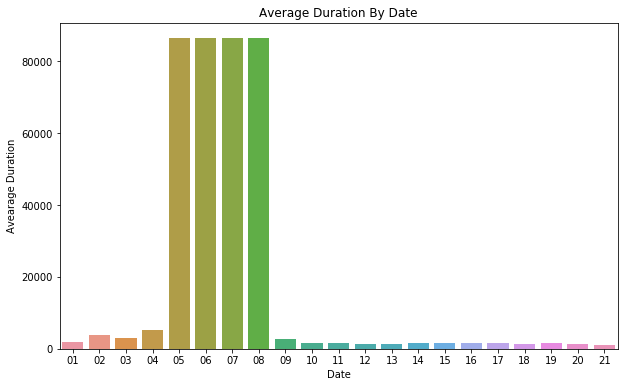

In [28]:
fig, axes = plt.subplots()
fig.set_size_inches(10,6)
dateAggregated = pd.DataFrame(initial_df.groupby("date")["duration"].mean()).reset_index()
dateSorted = dateAggregated.sort_values(by="duration",ascending=False)
dateSorted['date'] = dateSorted.astype("str")
dateSorted['Day']=[d.split('-')[2] for d in dateSorted.date]
sn.barplot(data=dateSorted,x="Day",y="duration")
axes.set(xlabel='Date', ylabel='Avearage Duration',title="Average Duration By Date")

## We will keep seeing abnormal graphs as the range of duration is very high

[Text(0, 0.5, 'Duration Count'),
 Text(0.5, 0, 'Hour Of The Day'),
 Text(0.5, 1.0, 'Average Duration By Hour Of The Day across Sensors'),
 None]

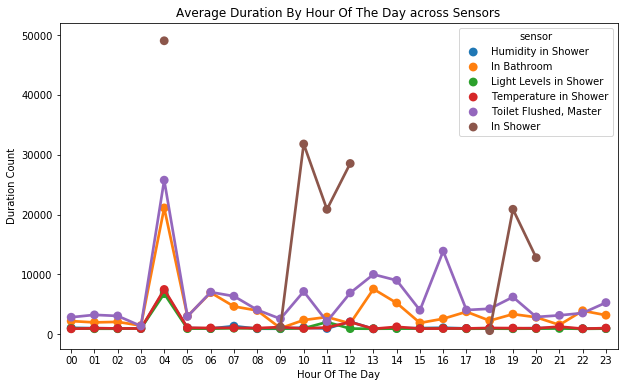

In [29]:
fig, axes = plt.subplots()
fig.set_size_inches(10,6)
hourAggregated = pd.DataFrame(initial_df.groupby(["hour","sensor"])["duration"].mean()).reset_index()
sn.pointplot(x=hourAggregated["hour"], y=hourAggregated["duration"],hue=hourAggregated["sensor"], data=hourAggregated)
axes.set(xlabel='Hour Of The Day', ylabel='Duration Count',title="Average Duration By Hour Of The Day across Sensors",label='big')

In [30]:
def round_int(x):
    if x == float("inf") or x == float("-inf"):
        return float('nan')
    return int(round(x))

In [31]:
initial_df['value_roundoff'] = initial_df.value.apply(round_int)

## our QQ plot shows a very skewed distribution of target variable Duration

##### These plots say that there are outliers for duration and we have to clean it before training

((array([-3.61782997, -3.38142161, -3.25106958, ...,  3.25106958,
          3.38142161,  3.61782997]),
  array([5.0000e-02, 1.2816e+01, 1.5060e+01, ..., 8.6400e+04, 8.6400e+04,
         8.6400e+04])),
 (3296.41652833832, 2200.581414059151, 0.4164913668051065))

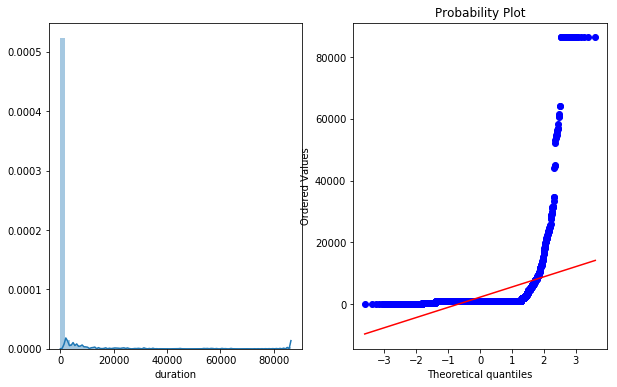

In [32]:
fig,axes = plt.subplots(ncols=2) 
fig.set_size_inches(10,6)
sn.distplot(initial_df["duration"],ax=axes[0])
stats.probplot(initial_df["duration"], dist='norm',plot=axes[1])

#### Plotting the average shower duration by taking only the data of shower sensor

[Text(0, 0.5, 'Avearage Duration'),
 Text(0.5, 0, 'Date'),
 Text(0.5, 1.0, 'Average Shower Duration By Date')]

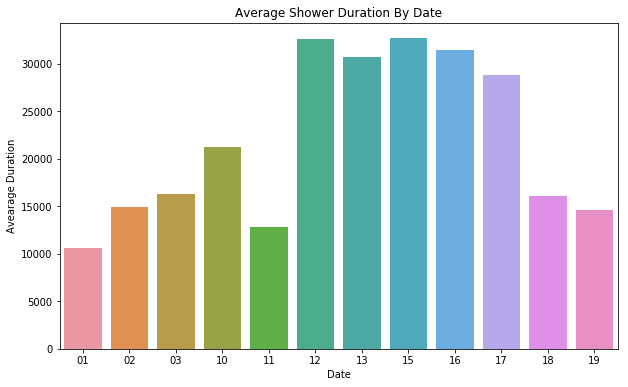

In [33]:
shower_duration = initial_df[(initial_df.sensor_id == 3802) & (initial_df.is_original == 1)]
fig, axes = plt.subplots()
fig.set_size_inches(10,6)
dateAggregated = pd.DataFrame(shower_duration.groupby("date")["duration"].mean()).reset_index()
dateSorted = dateAggregated.sort_values(by="duration",ascending=False)
dateSorted['date'] = dateSorted.astype("str")
dateSorted['Day']=[d.split('-')[2] for d in dateSorted.date]
sn.barplot(data=dateSorted,x="Day",y="duration")

axes.set(xlabel='Date', ylabel='Avearage Duration',title="Average Shower Duration By Date")

In [34]:
shower_duration_subset = shower_duration[['date','value']]
shower_duration_subset['date'] = pd.to_datetime(shower_duration_subset['date'], format='%Y-%m-%d')
shower_duration_subset['value'] = shower_duration_subset.value.astype(int)
shower_duration_subset = shower_duration_subset.sort_values(by="date")

### Plot of the average Temparature based only on data from Temparature sensor

(74, 79)

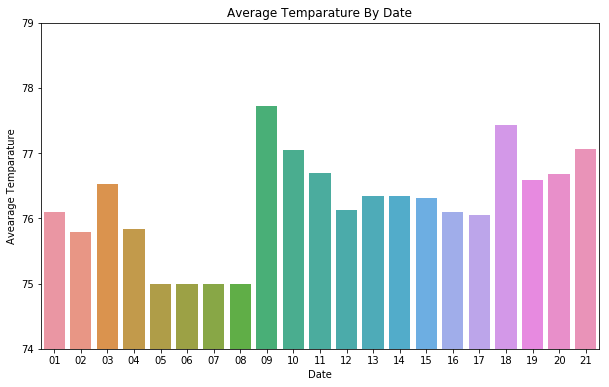

In [35]:
Temparature_shower = initial_df[initial_df.sensor_id == 3803]
fig, axes = plt.subplots()
fig.set_size_inches(10,6)
dateAggregated = pd.DataFrame(Temparature_shower.groupby("date")["value"].mean()).reset_index()
dateSorted = dateAggregated.sort_values(by="value",ascending=False)
dateSorted['date'] = dateSorted.astype("str")
dateSorted['Day']=[d.split('-')[2] for d in dateSorted.date]
sn.barplot(data=dateSorted,x="Day",y="value")
axes.set(xlabel='Date', ylabel='Avearage Temparature',title="Average Temparature By Date")
plt.ylim(74, 79)

[Text(0, 0.5, 'Date'),
 Text(0.5, 0, 'Average Light'),
 Text(0.5, 1.0, 'Average Light By Date')]

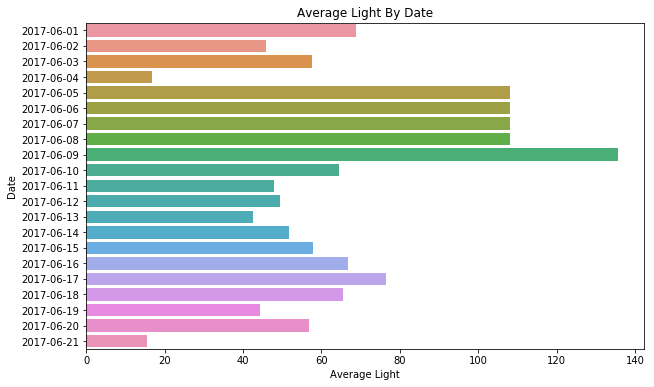

In [36]:
fig, axes = plt.subplots()
fig.set_size_inches(10,6)
light_shower =  initial_df[initial_df.sensor_id == 3804]
dateAggregated = pd.DataFrame(light_shower.groupby("date")["value"].mean()).reset_index()
dateAggregated['date'] = dateAggregated.astype("str")
sn.barplot(data=dateAggregated,x="value",y="date")
axes.set(xlabel='Average Light', ylabel='Date',title="Average Light By Date")

(42, 58)

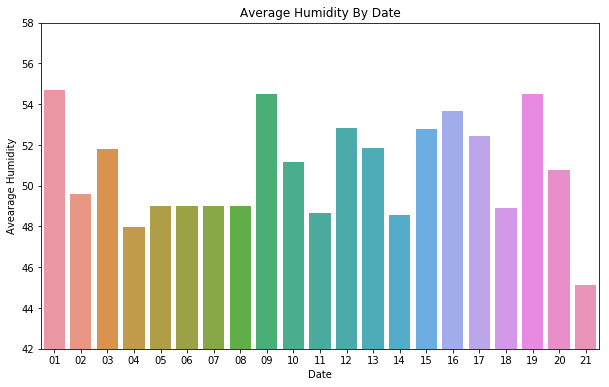

In [37]:
Humidity_shower = initial_df[initial_df.sensor_id == 3805]
fig, axes = plt.subplots()
fig.set_size_inches(10,6)
dateAggregated = pd.DataFrame(Humidity_shower.groupby("date")["value"].mean()).reset_index()
dateSorted = dateAggregated.sort_values(by="value",ascending=False)
dateSorted['date'] = dateSorted.astype("str")
dateSorted['Day']=[d.split('-')[2] for d in dateSorted.date]
sn.barplot(data=dateSorted,x="Day",y="value")
axes.set(xlabel='Date', ylabel='Avearage Humidity',title="Average Humidity By Date")
plt.ylim(42, 58)

Text(0, 0.5, 'Frequency')

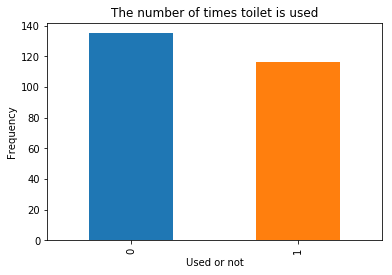

In [38]:
toilet_flushed = initial_df[initial_df.sensor_id ==3809]
count_classes = pd.value_counts(toilet_flushed['value'], sort = True).sort_index()
count_classes.plot(kind = 'bar')
plt.title("The number of times toilet is used")
plt.xlabel("Used or not")
plt.ylabel("Frequency")

### Cleaning data further more

In [39]:
initial_df['duration_roundoff'] = initial_df.duration.apply(round_int)

In [40]:
initial_df["weekday_num"] = initial_df.weekday.map({"Sunday" : 0, "Monday" : 1,
                                                 "Tuesday" : 2, "Wednesday" : 3,
                                                 "Thursday" : 4, "Friday" : 5,
                                                     "Saturday" : 6})


In [41]:
categoricalFeatureNames = ["sensor_id","is_original","hour","weekday_num"]
numericalFeatureNames = ["value_roundoff","duration_roundoff"]
dropFeatures = ['value',"start_time","end_time","duration","date","weekday"]

In [42]:
data_cleaned = pd.DataFrame()
for var in categoricalFeatureNames:
    data_cleaned[var] = initial_df[var].astype("category")

for var in numericalFeatureNames:
    data_cleaned[var] = initial_df[var].astype("int")


In [43]:
data_cleaned = data_cleaned[data_cleaned['duration_roundoff'] <= 900]  

### Splitting data into train and test

In [44]:
seed = 56
train, test = train_test_split(data_cleaned, test_size=0.2, random_state= seed)
print(train.shape)
test.shape

(3347, 6)


(837, 6)

In [45]:
X_train = train.drop("duration_roundoff",axis=1)
X_test = test.drop("duration_roundoff", axis=1)
y_train = train['duration_roundoff']
y_test = test['duration_roundoff']

##### Creating an rmsle error metric

In [46]:
def rmsle(y, y_,convertExp=True):
    if convertExp:
        y = np.exp(y),
        y_ = np.exp(y_)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

## Applying Random Forest

In [47]:
from sklearn.ensemble import RandomForestRegressor #importing random forest regressor
rfModel = RandomForestRegressor(n_estimators=100) 
#initializing the model and creating 100 trees

y_train_Log = np.log1p(y_train)
#y-axis

rfModel.fit(X_train,y_train_Log)
#fitting the model to train data

preds = rfModel.predict(X= X_train)
#predicting on test data

print ("RMSLE Value For Random Forest: ",rmsle(np.exp(y_train_Log),np.exp(preds),False))
#printing the error made by model

RMSLE Value For Random Forest:  0.13460331008052098


In [48]:
pred_y_test = rfModel.predict(X= X_test)
y_log_test = np.log1p(y_test)
print ("RMSLE Value For Random Forest on Test Dataset: ",rmsle(np.exp(y_log_test),np.exp(pred_y_test),False))

RMSLE Value For Random Forest on Test Dataset:  0.2586067052539262


In [49]:
import os
cwd = os.getcwd()

In [50]:
cwd


'D:\\USF\\USF_Health_care_GA\\Mohanaditya_deliverables\\Data_model'

In [51]:
#with open(cwd + "//rf.cpickle", 'wb') as f:
#    cPickle.dump(rfModel, f)


## Lets Try out GBM

In [52]:
from sklearn.ensemble import GradientBoostingRegressor

gbm = GradientBoostingRegressor(n_estimators=4000,alpha=0.01)

y_log_train = np.log1p(y_train)

gbm.fit(X_train,y_log_train)
#fittinng the model

pred_y_train = gbm.predict(X= X_train)

print ("RMSLE Value For Gradient Boosting on Train Dataset : ",rmsle(np.exp(y_log_train),np.exp(pred_y_train),False))
#printing the error

RMSLE Value For Gradient Boosting on Train Dataset :  0.13089104585897307


In [53]:
y_log_test = np.log1p(y_test)
pred_y_test = gbm.predict(X= X_test)
print ("RMSLE Value For Gradient Boost on Test Dataset: ",rmsle(np.exp(y_log_test),np.exp(pred_y_test),False))

RMSLE Value For Gradient Boost on Test Dataset:  0.2764141659830554


In [54]:
filename = 'gbm.sav'
#cPickle.dump(gbm, open(filename, 'wb'))

In [55]:
gbm_model = cPickle.load(open(filename, 'rb'))

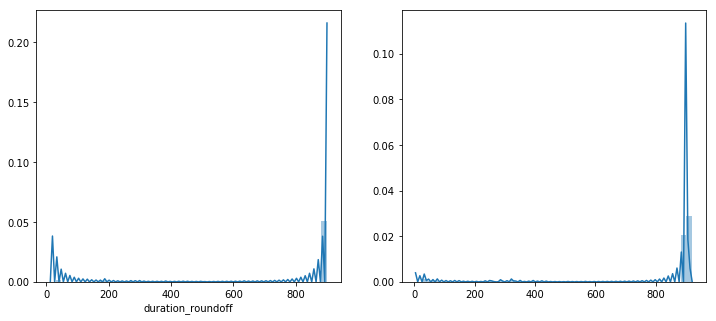

In [56]:
fig,(ax1,ax2)= plt.subplots(ncols=2)
fig.set_size_inches(12,5)
sn.distplot(y_test,ax=ax1,bins=50)
sn.distplot(np.exp(pred_y_test),ax=ax2,bins=50)